# XY-calibration (QSO)

In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    os.chdir("../../../FireBallPipe")
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
Elg = 0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg = 1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09171 ''/inc and Ce is 0.01018 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "QSO"
previous_xy_mapping = "Calibration/Mappings/2018/XY/Guider2UV_F3_nogamma.new.pkl"
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-2023-0-QSO_10125.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# # load model from previous XY calib 
# G2UV = Guider2UV(filename=previous_xy_mapping)
# #changer de centre 
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.1038940*u.deg, 1.594590*u.deg), rotation=(90-100)*u.deg, gamma=1)#QSO1
		
	
# # eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
# G2UV.mask_rotation = 0.0*u.arcmin
# G2UV.FieldP.gamma = 1. 
# G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
# G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
# print(G2UV)

# # if you already know the approx angular distance between guidercenter and FOVcenter, set it:
# # G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
# #                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
# #                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
#     raise ValueError("Please verify the initialization mapping")



## Alternative initialisation for new fields:
---------------------------------------

In [7]:

f_ra, f_dec, f_rot = 0.038940, 1.394590, 90-100
f_ra, f_dec, f_rot = 14.62883, 0.00512, 90-100
Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# get FOVcenter & guider wcs from another field
#  put pkl from a functionning mapping from another field
G2UVother = Guider2UV(filename=previous_xy_mapping)
FOVcenter = G2UVother.FOV_center_guider_coord
guider_wcs = G2UVother.GuiderP.w
G2UV = Guider2UV(Field_center=Field_center,
                 Field_rotation= f_rot * u.deg,
                 Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
                 FOVcenter_guider_coord=FOVcenter,
                 guider_wcs = guider_wcs,
                 )
                 
print(G2UV)

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.18212015, -0.00658703)>
FOV center pixel position in guider [array(1356.48459465), array(515.54397687)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-100.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (14.62883, 0.00512)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 0.0 deg
    FOV ce

## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [8]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([0.6,1.4])
diffuse_offset = np.array([0,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

['23', '36', '2', '13', '32', '11',"4"]

Here we struggled to find the good path because of faint 202/206 lines and of shadow of fiber holder

In [9]:
star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"
F1_stars = Table.read(star_target_path).to_pandas()


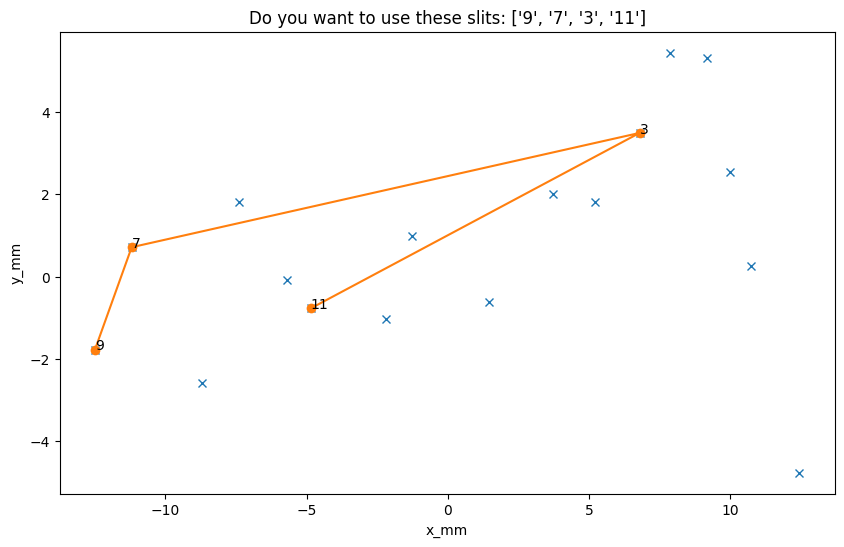

In [10]:
slits =[ '9', '16', '7',"3","10"]#pass only on QSO 3
slits =[ '9', '7',"3","11"]# short pass
F1['Internal-count'] = F1['Internal-count'].astype(str)

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.ylabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path


star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"
# il faut que le centre soit bien defini à l'arcseconde pres.
F1_stars = Table.read(star_target_path)#.to_pandas()
# stars = [2, 4, 5, 6, 7]
stars =  [13,14]#[2, 4, 5, 6, 7]
selected_stars = F1_stars[abs(F1_stars["RA"]-np.nanmean(selected_slits["RA"]))<2]
stars_and_slits = vstack([selected_stars["RA","DEC"],selected_slits["RA","DEC"]])

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [11]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [-12.49939635  -1.77959053]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]

targets local coords in siderostat local frame:
EL: 252.6 arcsec ; CE: -512.6 arcsec
EL: 359.3 arcsec ; CE: -457.7 arcsec
EL: 477.9 arcsec ; CE: 296.2 arcsec
EL: 295.8 arcsec ; CE: -191.6 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False the last move to return to the guider is not given. You just need to do -∑all moves
You should then add EL=295.7545 and CE=-191.5644


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [12]:
# fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")
# ax1.plot(-46*selected_slits["x_mm"],46*selected_slits["y_mm"],"o")
# ax1.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")


In [13]:

slits_coord_obs_det = np.array([
[ 383.6,	1993.1],
[ 547.7,	1889.7 ],
[ 716.8,	506.8],
[ 436.4,	1401.3  ],
]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.12047977, 0.3034625)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.18290078, 0.27000609)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.2558655, -0.1550481)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.1536532, 0.11924708)]>]

### look at siderostat frame hysteresis 

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation and translation
theta: -67.17190037744905 arcmin
dx: 40.39480958759247 arcsec
dy: -29.7916174284066 arcsec
variances: [2.55451324 0.5976605  0.71648676]

residuals in arcsec: [[-9.1619751   9.23583031]
 [ 0.72899654 -3.58719471]
 [-3.05882996 -3.59951214]
 [11.49180851 -2.04912347]]
max residual in EL,CE 11.5, 9.2 arcsec
mean residual in EL,CE 7.5, 5.4 arcsec
After updating:
    mask_rotation: -1.1195316729574842 deg
    FOV center in guider: 1398.4933551800345 x 469.8892503971581 pix = 695.5639950918976 arcsec x -66.31566547434213 arcsec arcsec
    mask_magnification correction: 1.0  
    
[ 0.01672918 -0.06424799 -0.14530453  0.1567953   0.21525528  0.27261118
  0.17713641] [-0.13739125  0.0186669   0.09974694  0.27887721  0.24667487 -0.18094157
  0.09686445]
[ 0.01672918 -0.06424799 -0.14530453  0.1567953   0.21525528  0.27261118
  0.17713641] [-0.13739125  0.0186669   0.09974694  0.27887721  0.24667487 -0.18094157
  0.09686445]


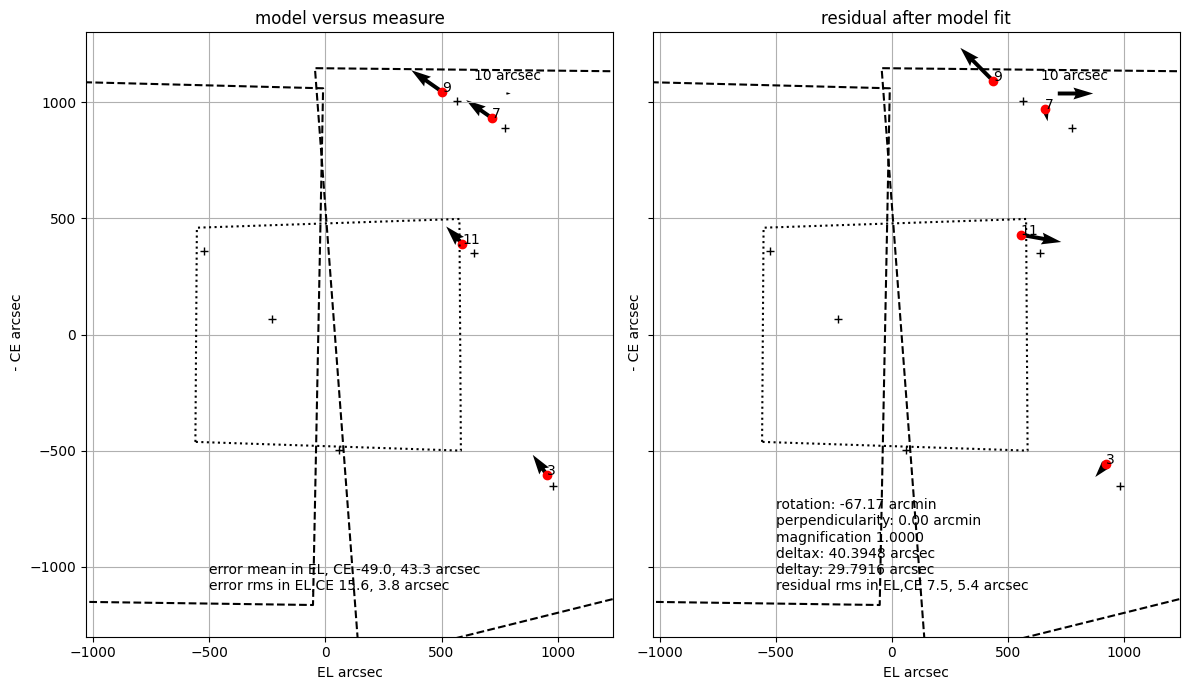


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [14]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7), labels=slits,selected_stars=stars_and_slits)


### check updating without fitting magnification


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-100.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (14.62883, 0.00512)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: -1.1195316729574842 deg
    FOV center in guider: 1398.4933551800345x469.8892503971581 pix

Fitting rotation, translation and magnification
gamma: 0.9958937520463271
theta: -67.1719003774491 arcmin
dx: 43.23064000450965 arcsec
dy: -27.98234319852815 arcsec
variances: [7.43077779e-04 2.55451324e+00 7.87750

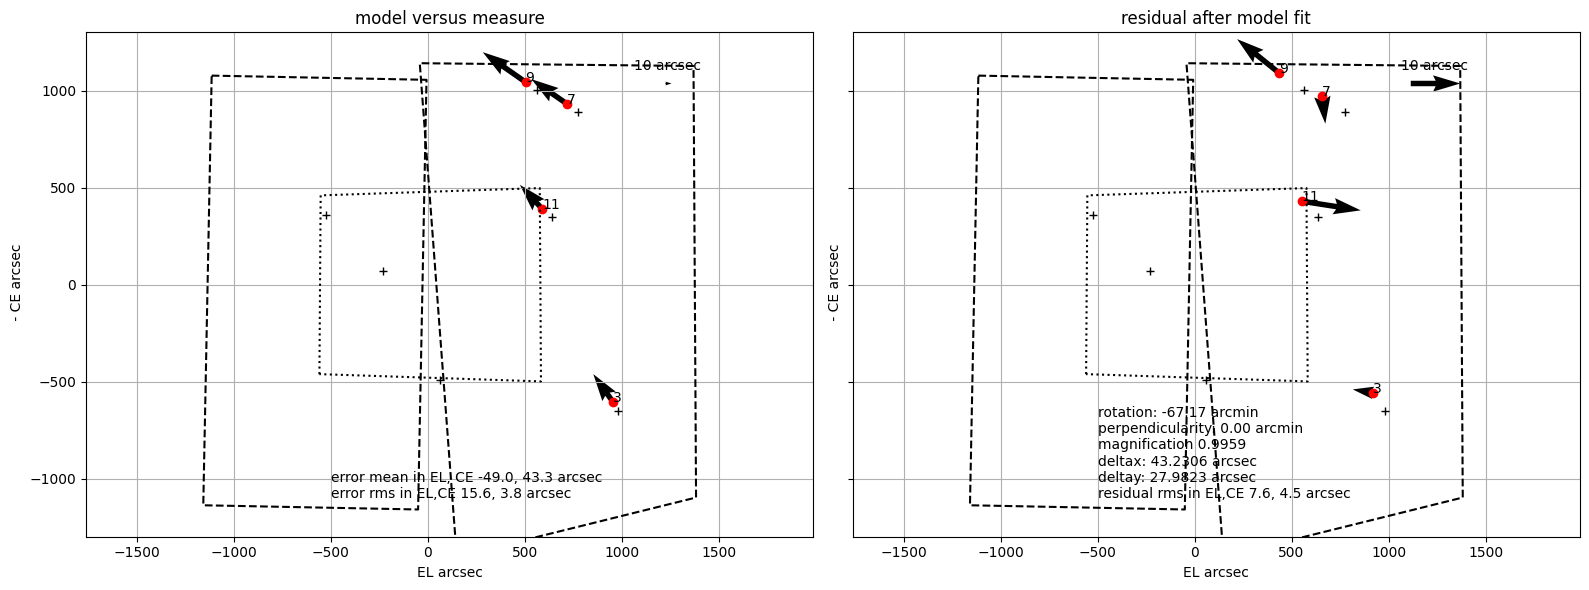


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [17]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,selected_stars=stars_and_slits,inplace=False)


### Verify what magnification it predicts
### save corrected model for future use (eg redo the calib on same field)

## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

slit position in mm on mask: [-12.49939635  -1.77959053]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]

targets local coords in siderostat local frame:
EL: 283.1 arcsec ; CE: -493.1 arcsec
EL: 388.7 arcsec ; CE: -436.2 arcsec
EL: 492.2 arcsec ; CE: 319.9 arcsec
EL: 319.8 arcsec ; CE: -171.3 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


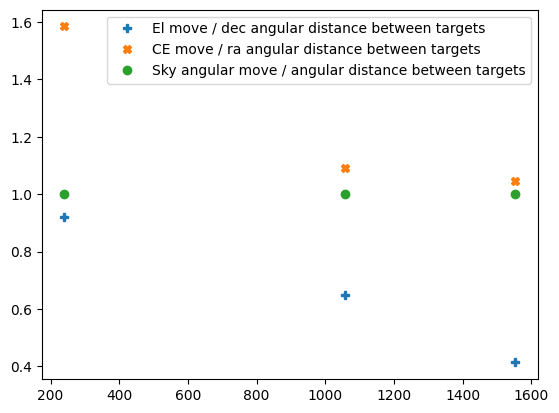

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9,-12.499396354705528,-1.7795905324848371,14.34419,-0.08793,-73.15191385601173,-228.81599999999997,240.2248204428455,105.55553212267284,56.94000658781537,210.45661994618513,115.92985341279208,240.27425952749175,1.000205803399312,-0.9197635652497428,-1.584782233325872
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,-1470.4198669921757,-499.39199999999994,1552.9091908122919,103.5621401053168,756.1020769811353,206.48219494198065,1539.4238287335913,1553.2097801973975,1.000193565333301,-0.413467165957766,-1.0469280667994285
3,6.7942147847059475,3.485314424962899,14.772960000000001,0.11435,914.8661779706479,530.028,1057.3125386462705,-172.38899744456583,-491.2093984584068,-343.70918310497535,-1000.1023352613162,1057.5162805110035,1.0001926978611204,-0.6484736336664767,-1.0931678964017872


In [18]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

wave:  0.20619
Fitting rotation and translation
theta: 24.227562475418498 arcmin
dx: -7.875676306814461 arcsec
dy: -6.683179875452514 arcsec
variances: [3.03836967 0.6025549  0.91146893]

residuals in arcsec: [[-6.01863531  2.82095565]
 [-1.9775597  -4.81607311]
 [ 7.99619501  1.99511746]]
max residual in EL,CE 8.0, 4.8 arcsec
mean residual in EL,CE 5.9, 3.4 arcsec
After updating:
    mask_rotation: -0.7157389650338426 deg
    FOV center in guider: 1390.6507590065103 x 467.9133632378154 pix = 688.1556792498017 arcsec x -68.09684957455234 arcsec arcsec
    mask_magnification correction: 1.0  
    
[ 0.01553373 -0.0665317  -0.14814827  0.15264803  0.21132682  0.27168732
  0.17426859] [-0.13911294  0.01635326  0.09685111  0.27808496  0.2462989  -0.18085462
  0.09624055]
[ 0.01553373 -0.0665317  -0.14814827  0.15264803  0.21132682  0.27168732
  0.17426859] [-0.13911294  0.01635326  0.09685111  0.27808496  0.2462989  -0.18085462
  0.09624055]


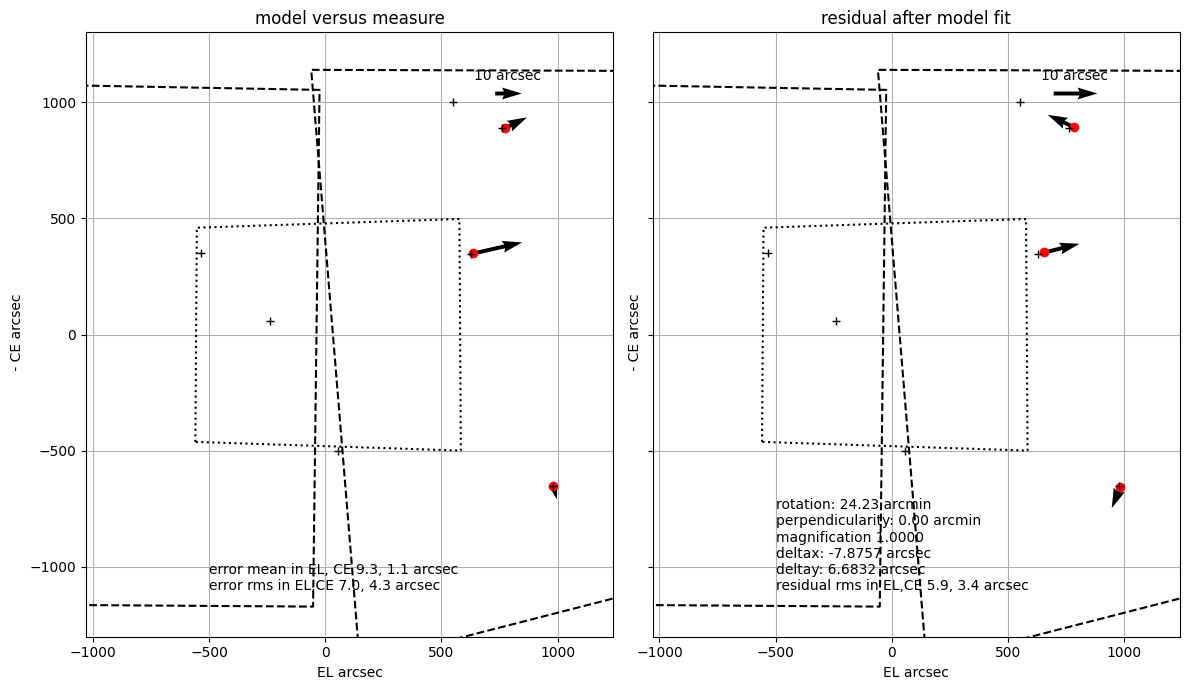


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            
slit position in mm on mask: [-12.49939635  -1.77959053]
slit position in mm on mask: [-11.19602978 

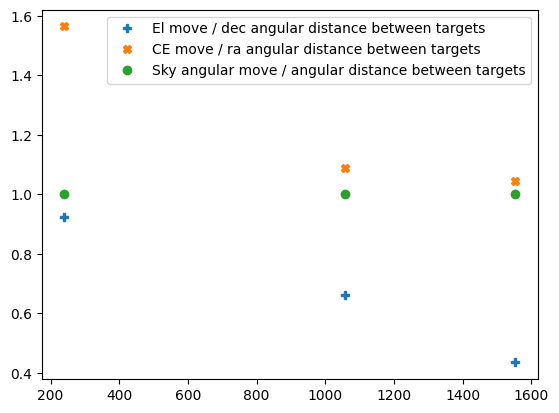

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9,-12.499396354705528,-1.7795905324848371,14.34419,-0.08793,-73.15191385601173,-228.81599999999997,240.2248204428455,105.95062460406433,56.20396161070076,211.24435533558346,114.43126583938675,240.2471482926502,1.0000929456405192,-0.9232062239335689,-1.5642962679640489
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,-1470.4198669921757,-499.39199999999994,1552.9091908122919,108.98723037984317,755.2835426845656,217.2987399313313,1537.7572929057758,1553.03452449089,1.000080708955385,-0.4351265938007244,-1.0457946926760058
3,6.7942147847059475,3.485314424962899,14.772960000000001,0.11435,914.8661779706479,530.028,1057.3125386462705,-175.89899399625094,-489.9525041993629,-350.70741422972515,-997.5432985499029,1057.396956151057,1.0000798415810852,-0.6616771457917792,-1.0903707258723336


In [19]:
slits_coord_obs_det = np.array([
[ 435.4,	1964.8],
[ 597.6,	1856.9],
[ 744.2,	459.3],
[ 479.6,	1370.5],
]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7),selected_stars=stars_and_slits)#, labels=slits_valid


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"



In [20]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field3.pkl")

Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field3.pkl



## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence We begin by QSO 5
 [29, 34, 18, 14]
we did not have the time to do this because G2UV was not well

Selected star =  Internal count     RA       DEC   
-------------- --------- ---------
            13 14.779574 -0.145077
            14 14.642088  -0.25461
            15 14.578173 -0.349763

targets local coords in siderostat local frame:
EL: 28.0 arcsec ; CE: 246.0 arcsec
EL: -120.1 arcsec ; CE: -28.9 arcsec

siderostat moves sequence: 
'numpy.float64' object is not iterable
[ 0.01553373 -0.0665317  -0.14814827] [-0.13911294  0.01635326  0.09685111]
[ 0.01553373 -0.0665317  -0.14814827] [-0.13911294  0.01635326  0.09685111]


/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:738: RuntimeWarning: Mean of empty slice.
  delta_mean = delta.mean(axis=0)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:739: RuntimeWarning: Mean of empty slice.
  delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0)) * 3600
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:771: RuntimeWarning: Mean of empty slice.
  residual_rms = np.sqrt(np.square(residuals).mean(axis=0)) * 3600
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


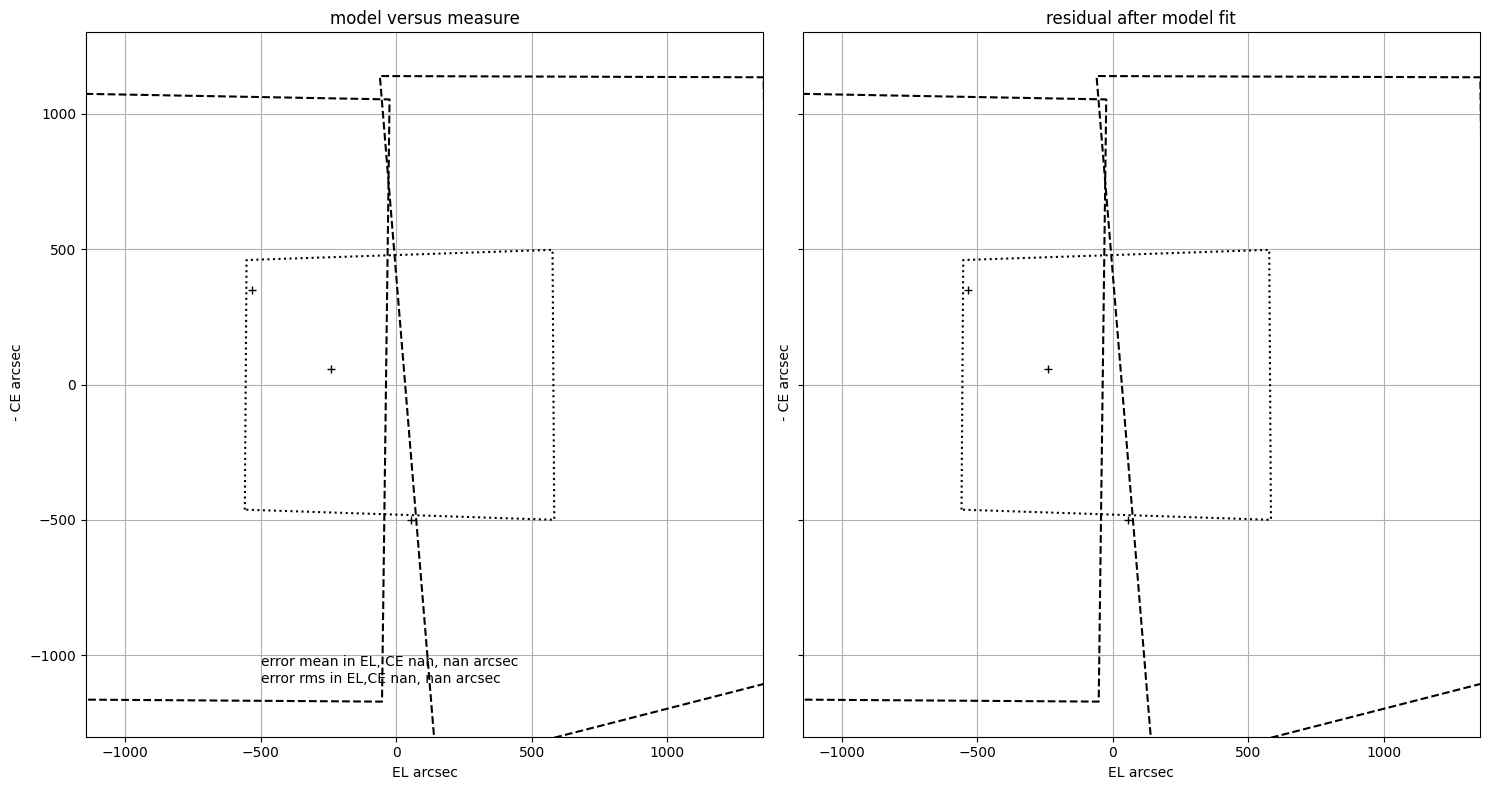

In [22]:
star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"
# il faut que le centre soit bien defini à l'arcseconde pres.
# F1_stars = Table.read(star_target_path).to_pandas()
# stars = [2, 4, 5, 6, 7]
# stars =  [13,14]#[2, 4, 5, 6, 7]
selected_stars = F1_stars[abs(F1_stars["RA"]-np.nanmean(selected_slits["RA"]))<2]
print("Selected star = ",selected_stars["Internal count","RA","DEC"])

# selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves

G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10,G2UVcor=None,selected_stars=selected_stars)


Selected star =  Internal count     RA      DEC   
-------------- --------- --------
             8 22.374342 0.385839
             9 22.449162 0.275816
            10 22.470774 0.374579
            11  22.39439 0.358427
            12 22.455571 0.580502
Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field2.pkl
'numpy.float64' object is not iterable


/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:733: RuntimeWarning: Mean of empty slice.
  delta_mean = delta.mean(axis=0)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:734: RuntimeWarning: Mean of empty slice.
  delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0)) * 3600
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:766: RuntimeWarning: Mean of empty slice.
  residual_rms = np.sqrt(np.square(residuals).mean(axis=0)) * 3600
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


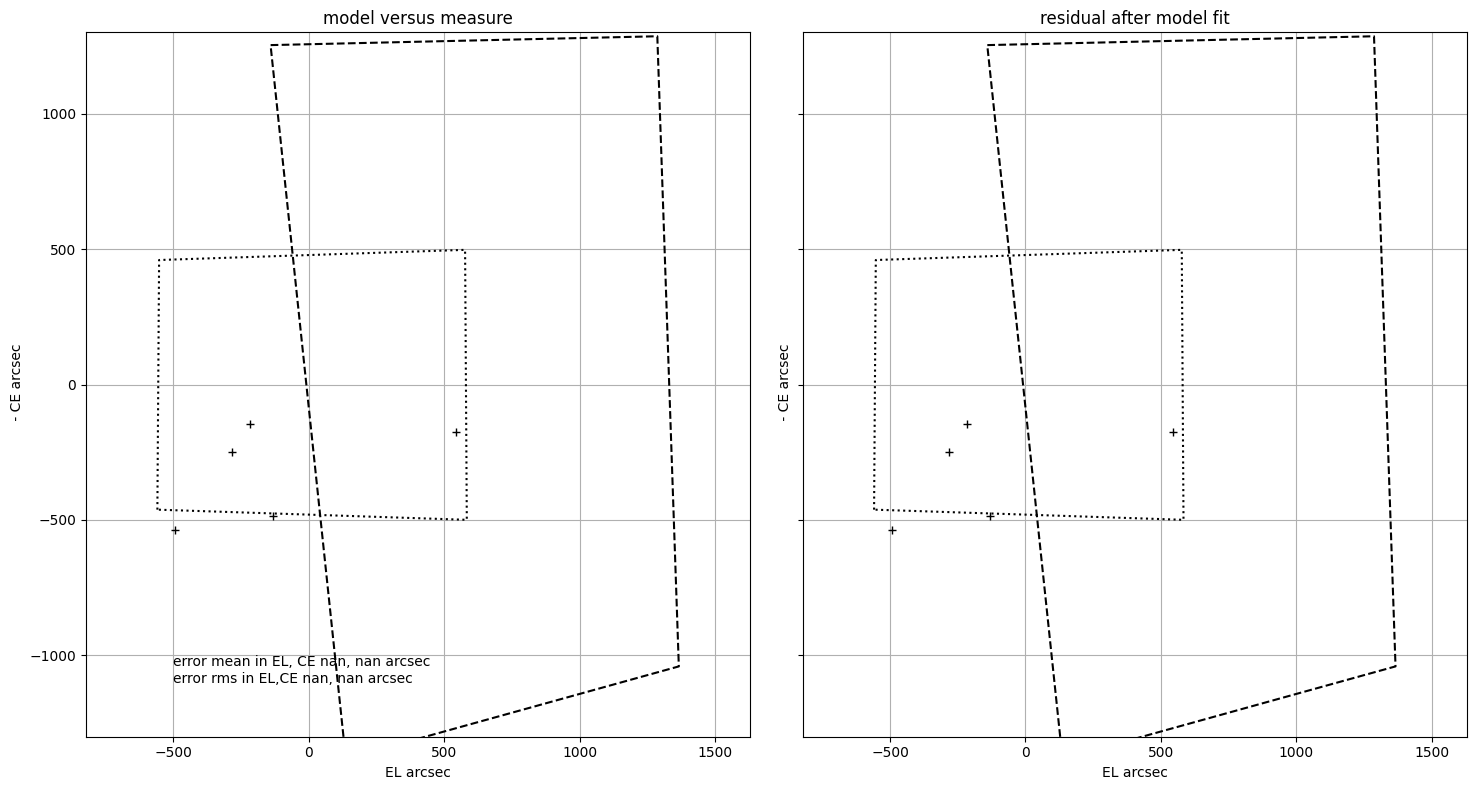

In [96]:

# stars = [8, 10, 12] #QSO7
#back to guider center
#Load new 
ra, dec, angle = 22.42638, 0.62279, (90-70)
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=angle*u.deg, gamma=1)
selected_stars = F1_stars[(abs(F1_stars["RA"]-ra)<1)|(abs(F1_stars["RA"]-ra)>359)]
print("Selected star = ",selected_stars["Internal count","RA","DEC"])

# selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
selected_stars.to_pandas().to_clipboard()
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field2.pkl")
G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10,G2UVcor=None,selected_stars=selected_stars)

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363



In [97]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()




targets local coords in siderostat local frame:
EL: -25515.4 arcsec ; CE: -48748.9 arcsec
EL: -25161.4 arcsec ; CE: -48507.7 arcsec
EL: -25118.0 arcsec ; CE: -48520.3 arcsec
EL: -25256.4 arcsec ; CE: -48413.9 arcsec
EL: -25351.1 arcsec ; CE: -48369.9 arcsec

siderostat moves sequence: 


Selected star =  Internal count     RA        DEC   
-------------- ---------- ---------
            16  351.96842 -2.126415
            17 351.719117 -1.990274
            18 351.915116 -1.887787
            19 351.917335  -1.86546
            20 351.944342 -1.952026
            21 351.947933 -2.004666
Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl

targets local coords in siderostat local frame:
EL: 80.3 arcsec ; CE: -223.4 arcsec
EL: 267.8 arcsec ; CE: 121.6 arcsec
EL: 308.2 arcsec ; CE: 125.3 arcsec
EL: 152.2 arcsec ; CE: 174.1 arcsec
EL: 57.2 arcsec ; CE: 181.1 arcsec

siderostat moves sequence: 
'numpy.float64' object is not iterable


/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:733: RuntimeWarning: Mean of empty slice.
  delta_mean = delta.mean(axis=0)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:734: RuntimeWarning: Mean of empty slice.
  delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0)) * 3600
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:766: RuntimeWarning: Mean of empty slice.
  residual_rms = np.sqrt(np.square(residuals).mean(axis=0)) * 3600
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


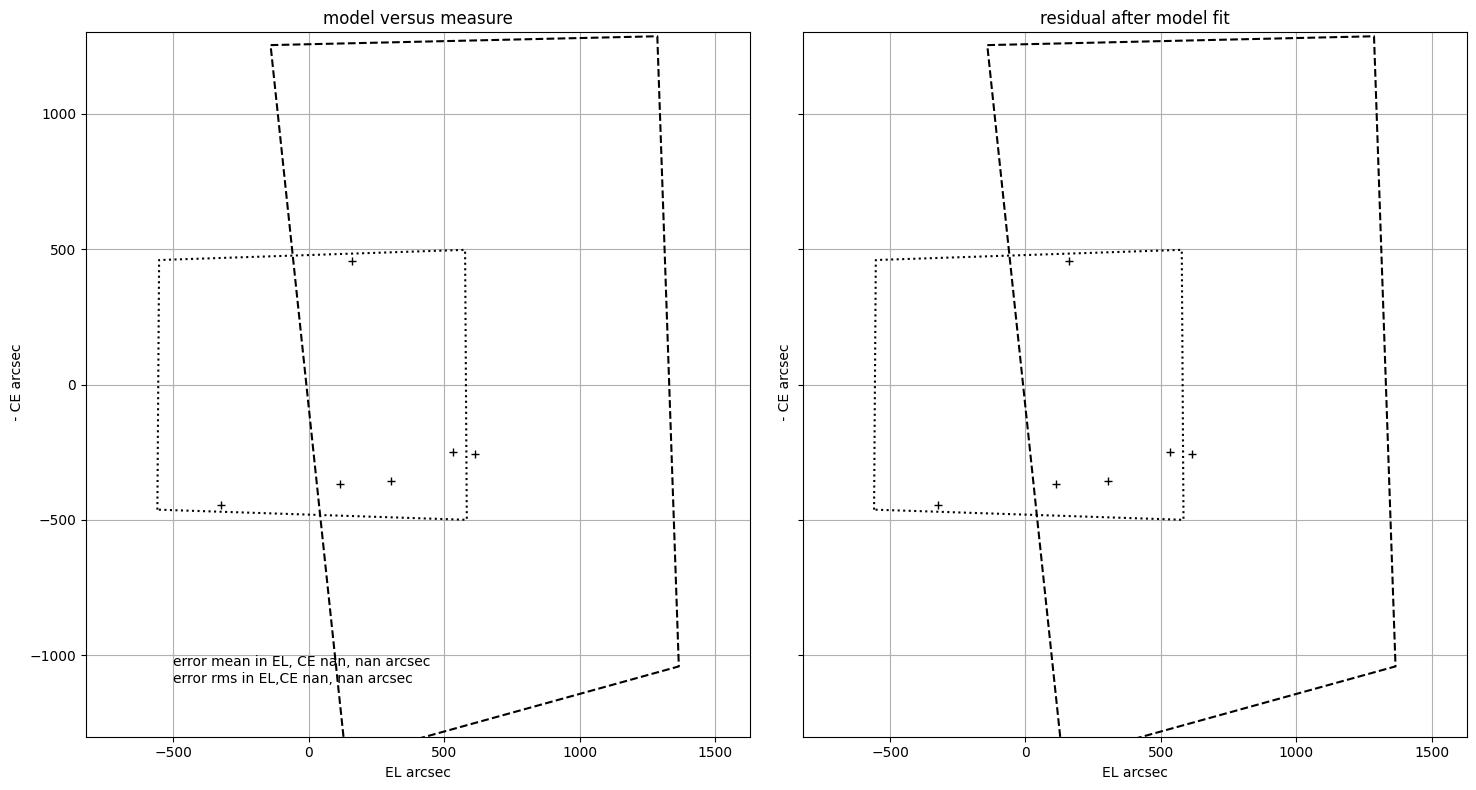

In [98]:



# stars = [17, 18, 19, 20, 21] #QSOV 14
#back to guider center
ra, dec, angle =351.8533, -1.8553, 0

# G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(351.8533*u.deg, -1.8553*u.deg), rotation=0*u.deg, gamma=1)
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=angle*u.deg, gamma=1)
selected_stars = F1_stars[(abs(F1_stars["RA"]-ra)<1)|(abs(F1_stars["RA"]-ra)>359)]
print("Selected star = ",selected_stars["Internal count","RA","DEC"])

# selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves
G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10,G2UVcor=None,selected_stars=selected_stars)


In [99]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: 80.3 arcsec ; CE: -223.4 arcsec
EL: 267.8 arcsec ; CE: 121.6 arcsec
EL: 308.2 arcsec ; CE: 125.3 arcsec
EL: 152.2 arcsec ; CE: 174.1 arcsec
EL: 57.2 arcsec ; CE: 181.1 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field1.pkl
Selected star =  Internal count     RA       DEC   
-------------- ---------- --------
             1   0.000872 1.088979
             2   0.064613 1.207946
             3   0.143461 1.066249
             4 359.996741 1.239476
             5   0.002719 1.247124
             6     0.0266 1.331968
             7   0.038536 1.289373

targets local coords in siderostat local frame:
EL: -3219.4 arcsec ; CE: -15486.7 arcsec
EL: -3093.3 arcsec ; CE: -15115.4 arcsec
EL: -3053.7 arcsec ; CE: -15105.0 arcsec
EL: -3217.7 arcsec ; CE: -15083.0 arcsec
EL: -3313.6 arcsec ; CE: -15091.9 arcsec

siderostat moves sequence: 
'numpy.float64' object is not iterable


/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:733: RuntimeWarning: Mean of empty slice.
  delta_mean = delta.mean(axis=0)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:734: RuntimeWarning: Mean of empty slice.
  delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0)) * 3600
/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:766: RuntimeWarning: Mean of empty slice.
  residual_rms = np.sqrt(np.square(residuals).mean(axis=0)) * 3600
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


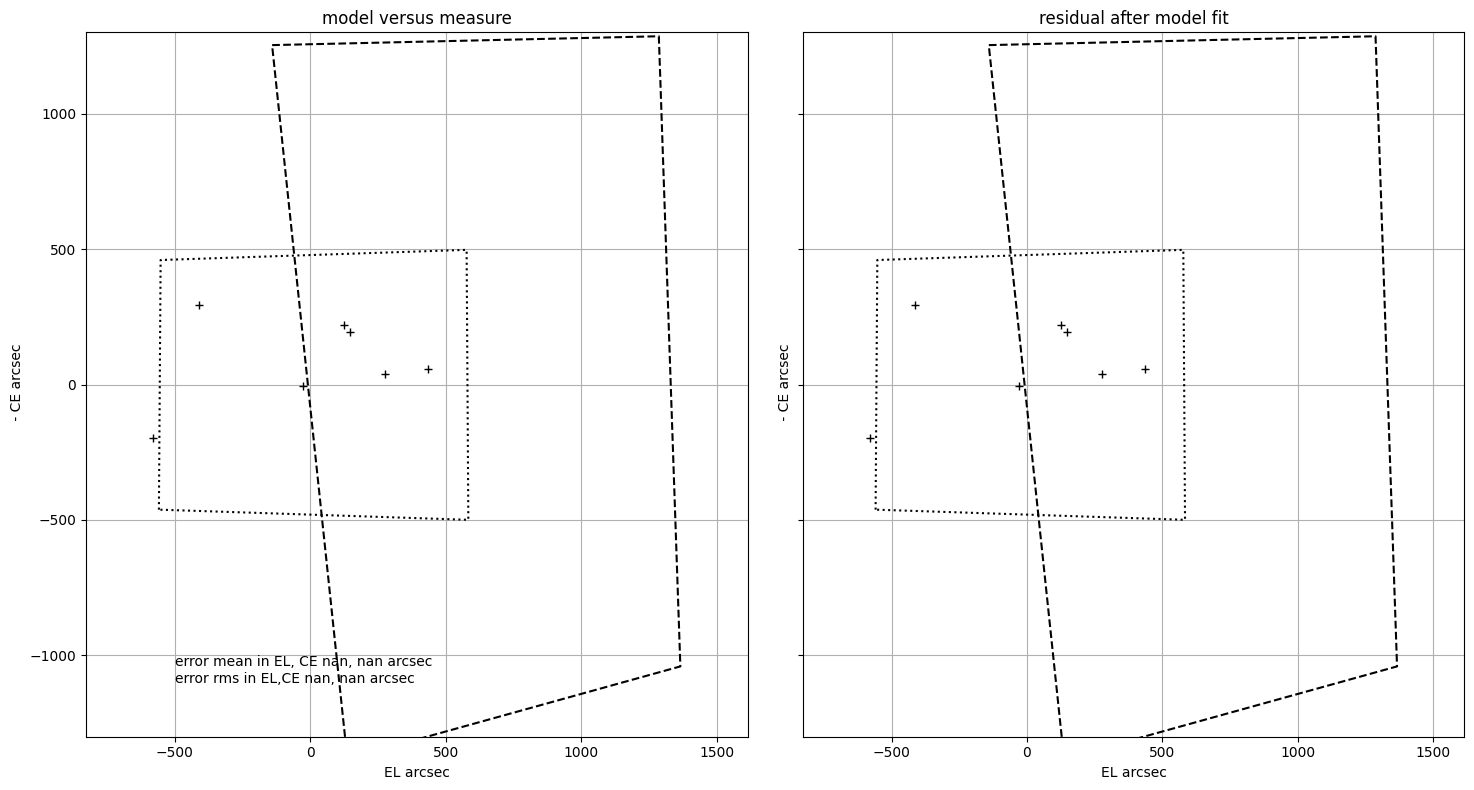

In [100]:
# stars =  [2, 4, 5, 6, 7] #QSOV 1
#back to guider center
ra, dec, angle = 0.0389, 1.39459,(90-100)

# G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.03894*u.deg, 1.39459*u.deg), rotation=(90-100)*u.deg, gamma=1)
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=angle*u.deg, gamma=1)
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field1.pkl")

# selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
selected_stars = F1_stars[(abs(F1_stars["RA"]-ra)<1)|(abs(F1_stars["RA"]-ra)>359)]
print("Selected star = ",selected_stars["Internal count","RA","DEC"])
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10,G2UVcor=None,selected_stars=selected_stars)


In [101]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: -3219.4 arcsec ; CE: -15486.7 arcsec
EL: -3093.3 arcsec ; CE: -15115.4 arcsec
EL: -3053.7 arcsec ; CE: -15105.0 arcsec
EL: -3217.7 arcsec ; CE: -15083.0 arcsec
EL: -3313.6 arcsec ; CE: -15091.9 arcsec

siderostat moves sequence: 


In [102]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

KeyError: 'X'

The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------